In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import Image
from IPython.display import HTML
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Solution Overview

* **Data Understanding**
    * missing values
    * imputation
    * Data type check
    


* **EDA**
    * Univariate analysis, continuous and categorical
    * Provide statements for the trends observed.
    * correlation of numeric variables with target variable necessary condition for the regressino.
    * Provide statements for the trends observed.
 

* **Model Building and evaluation**
    * Data preparation, dummy variable creation.
    * Scratch model with all the variables first.
    * Build regularized model using grid search and find optimal alpha for ridge and lasso.
    * Retrain regularized model with optimal alpha values.
    * Model evaluation, comparison of R2, RSS, MSE across Non regularized, ridge and lasso model.
    * Explain the final model's predictor variables with statements.

### Things to report

* We need to build a model which could predict the price of the houses at inflated rate compared to the previously created quotations.

* Top variables which contribute to the pricing needs to be recognised and their weights are needed to be reported.

* Optimal value of the lambda i.e. the regularization effect.


## Data Understanding

In [2]:
# Load the dataset into dataframe

df_main = pd.read_csv("./train.csv")

In [3]:
df_main.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Print the information about all the columns in the dataframe.

df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### There are total 81 columns with 1460 entries in the dataset, with int, float and object being the dtype of the different columns.

### Missing Values

In [5]:
# Check the Missing values percentage per column

miss_per = (df_main.isnull().sum()/len(df_main))*100
miss_per_gr_0 = {miss_per.keys()[idx] : miss_per[idx] for idx, val in enumerate(miss_per) if val > 0.0}
miss_per_gr_0 

{'LotFrontage': 17.73972602739726,
 'Alley': 93.76712328767123,
 'MasVnrType': 0.547945205479452,
 'MasVnrArea': 0.547945205479452,
 'BsmtQual': 2.5342465753424657,
 'BsmtCond': 2.5342465753424657,
 'BsmtExposure': 2.6027397260273974,
 'BsmtFinType1': 2.5342465753424657,
 'BsmtFinType2': 2.6027397260273974,
 'Electrical': 0.0684931506849315,
 'FireplaceQu': 47.26027397260274,
 'GarageType': 5.5479452054794525,
 'GarageYrBlt': 5.5479452054794525,
 'GarageFinish': 5.5479452054794525,
 'GarageQual': 5.5479452054794525,
 'GarageCond': 5.5479452054794525,
 'PoolQC': 99.52054794520548,
 'Fence': 80.75342465753424,
 'MiscFeature': 96.30136986301369}

#### The features LotFrontage, Alley, FireplaceQu, PoolQC, Fence and MiscFeature have a significant number of missing values. Since the total number of datapoints are also very limited, an imputation for 15-20 percentage of missing values can lead to bias in the feature representation. Therefore going by the heuristic of removing the column missing values greater than 15 percentage.

In [6]:
# Drop the above filtered columns 
drop_cols = ["LotFrontage", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df_main.drop(drop_cols, axis=1, inplace=True)

In [7]:
# Check if the columns have been dropped with assertion
checker = [1 if col in drop_cols else 0 for col in df_main.columns]
assert sum(checker) == 0, 'The dropped cols is still present in the dataframe, please check again'


### Imputation 

In [8]:
# Impute the value for above remained columns in the missing values list
impute_cols = list(set(miss_per_gr_0.keys()) - set(drop_cols))
impute_cols

['GarageYrBlt',
 'BsmtCond',
 'MasVnrType',
 'MasVnrArea',
 'GarageFinish',
 'BsmtQual',
 'GarageCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageQual',
 'BsmtFinType1',
 'GarageType']

In [9]:
"""
Imputation function to print the value of mean, median and mode for all the columns before and after imputation.
Check which one is the most stable one.
If the column in categorical, the value is imputed by the mode.
Otherwise for the continuous variable we will check.
"""  

def imputation(df, col_list):
    
    # Check the dtype of the column, based on which the further checks to be made.
    
    for col in col_list:
        
        if df[col].dtypes.name == 'object':
            
            # Add statment to impute with mode.
            print('Categorical Variable')
            print(f'Imputing {col} with dtype {df[col].dtype.name} using mode')
            df[col] = df[col].fillna(df[col].mode()[0])
            print(df[col].isnull().sum())
            print(f'mode : {df[col].mode()}')
        else:
            # Mean imputation for the continuous variables
            print('Numeric Variable')
            print(f'Imputing {col} with dtype {df[col].dtype.name} using mean')
            df[col] = df[col].fillna(df[col].mean())
            print(df[col].isnull().sum())
            print(f'mean : {df[col].mean()}')
            
            

In [10]:
# Perform imputation
imputation(df_main, impute_cols)

Numeric Variable
Imputing GarageYrBlt with dtype float64 using mean
0
mean : 1978.5061638868744
Categorical Variable
Imputing BsmtCond with dtype object using mode
0
mode : 0    TA
dtype: object
Categorical Variable
Imputing MasVnrType with dtype object using mode
0
mode : 0    None
dtype: object
Numeric Variable
Imputing MasVnrArea with dtype float64 using mean
0
mean : 103.68526170798899
Categorical Variable
Imputing GarageFinish with dtype object using mode
0
mode : 0    Unf
dtype: object
Categorical Variable
Imputing BsmtQual with dtype object using mode
0
mode : 0    TA
dtype: object
Categorical Variable
Imputing GarageCond with dtype object using mode
0
mode : 0    TA
dtype: object
Categorical Variable
Imputing BsmtExposure with dtype object using mode
0
mode : 0    No
dtype: object
Categorical Variable
Imputing BsmtFinType2 with dtype object using mode
0
mode : 0    Unf
dtype: object
Categorical Variable
Imputing Electrical with dtype object using mode
0
mode : 0    SBrkr
dtype:

#### All the columns with missing values have been imputed.

### Dtype Check



In [11]:
# Whethere the each of the element for each of the column has consistent data type w.r.t the defined datatype for the column.

def dtype_checker(df):
    list_n_datatype = [1 if (np.array_equal(df[f"{col}"], 
                       df[f"{col}"].astype(df[col].dtype))) else 0 
                       for col in df.columns]
    default_cols = None

    # List stores [1, 0, ...] where 1 means the datatype matches for each of the element for the column 
    # with defined datatype else 0

    # Check if the sum of the list_n_datatype == len(list_n_datatype) -> all datatypes are consistent

    if sum(list_n_datatype) == len(list_n_datatype):
        print('Dtypes are consistent')

    else : 
        print('Inconsistenct dtypes found')
        default_cols = [col for col in df.columns if not (np.array_equal(df[f"{col}"], 
                       df[f"{col}"].astype(df[col].dtype)))]
        print(f'Columns List : {default_cols}')
        
        print('Unique values in the defaulted cols')
        print([df[col].unique() for col in default_cols])

    

In [12]:
default_cols = dtype_checker(df_main)

Dtypes are consistent


#### The dtype check for the columns is successul. No discrepencies in the value dtype across different columns

## Exploratory Data Analysis

### Univariate Analysis

In [13]:
# Segregate numeric and categorical cols for Exploratory analysis

numeric_cols = [col for col in df_main.columns if not df_main[col].dtypes.name == 'object']
categ_cols = [col for col in df_main.columns if df_main[col].dtypes.name == 'object']
print(f'Number of Categorical Columns : {len(categ_cols)}')
print(f'Number of Numerical Columns : {len(numeric_cols)}')

Number of Categorical Columns : 38
Number of Numerical Columns : 37


In [14]:
# Categorical columns plot

def plot_categ(nrows, ncols, df, categ_cols, figsize):

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    index = 0
    if nrows > 1:
        for row in range(nrows):
            for col in range(ncols):
                if index < len(categ_cols):
                    r = random.random()
                    b = random.random()
                    g = random.random()
                    y = [val for key, val in df[categ_cols[index]].value_counts().iteritems()]
                    x = [n for n in range(len(y))]
                    ax[row][col].bar(x, y, color=(r,g,b)) 
                    ax[row][col].set_xlabel('Categories', fontsize=12)
                    ax[row][col].set_ylabel('Frequency', fontsize=12)
                    ax[row][col].set_title(f'{categ_cols[index]} - Class Frequency Plot')
                    plt.sca(ax[row][col])
                    plt.xticks(range(len(x)), [key for key, val in df[categ_cols[index]].value_counts().iteritems()],rotation=90)
                    ax[row][col].grid()
                else :
                    ax[row, col].axis('off')

                index +=1
    else:
        for row in range(nrows):
            for col in range(ncols):
                if index < len(categ_cols):
                    r = random.random()
                    b = random.random()
                    g = random.random()
                    y = [val for key, val in df[categ_cols[index]].value_counts().iteritems()]
                    x = [n for n in range(len(y))]
                    ax[col].bar(x, y, color=(r,g,b)) 
                    ax[col].set_xlabel('Categories', fontsize=12)
                    ax[col].set_ylabel('Frequency', fontsize=12)
                    ax[col].set_title(f'{categ_cols[index]} - Class Frequency Plot')
                    plt.sca(ax[col])
                    plt.xticks(range(len(x)), [key for key, val in df[categ_cols[index]].value_counts().iteritems()],rotation=90)
                    ax[col].grid()
                else :
                    ax[col].axis('off')

                index +=1
        

    fig.tight_layout()
    plt.show()

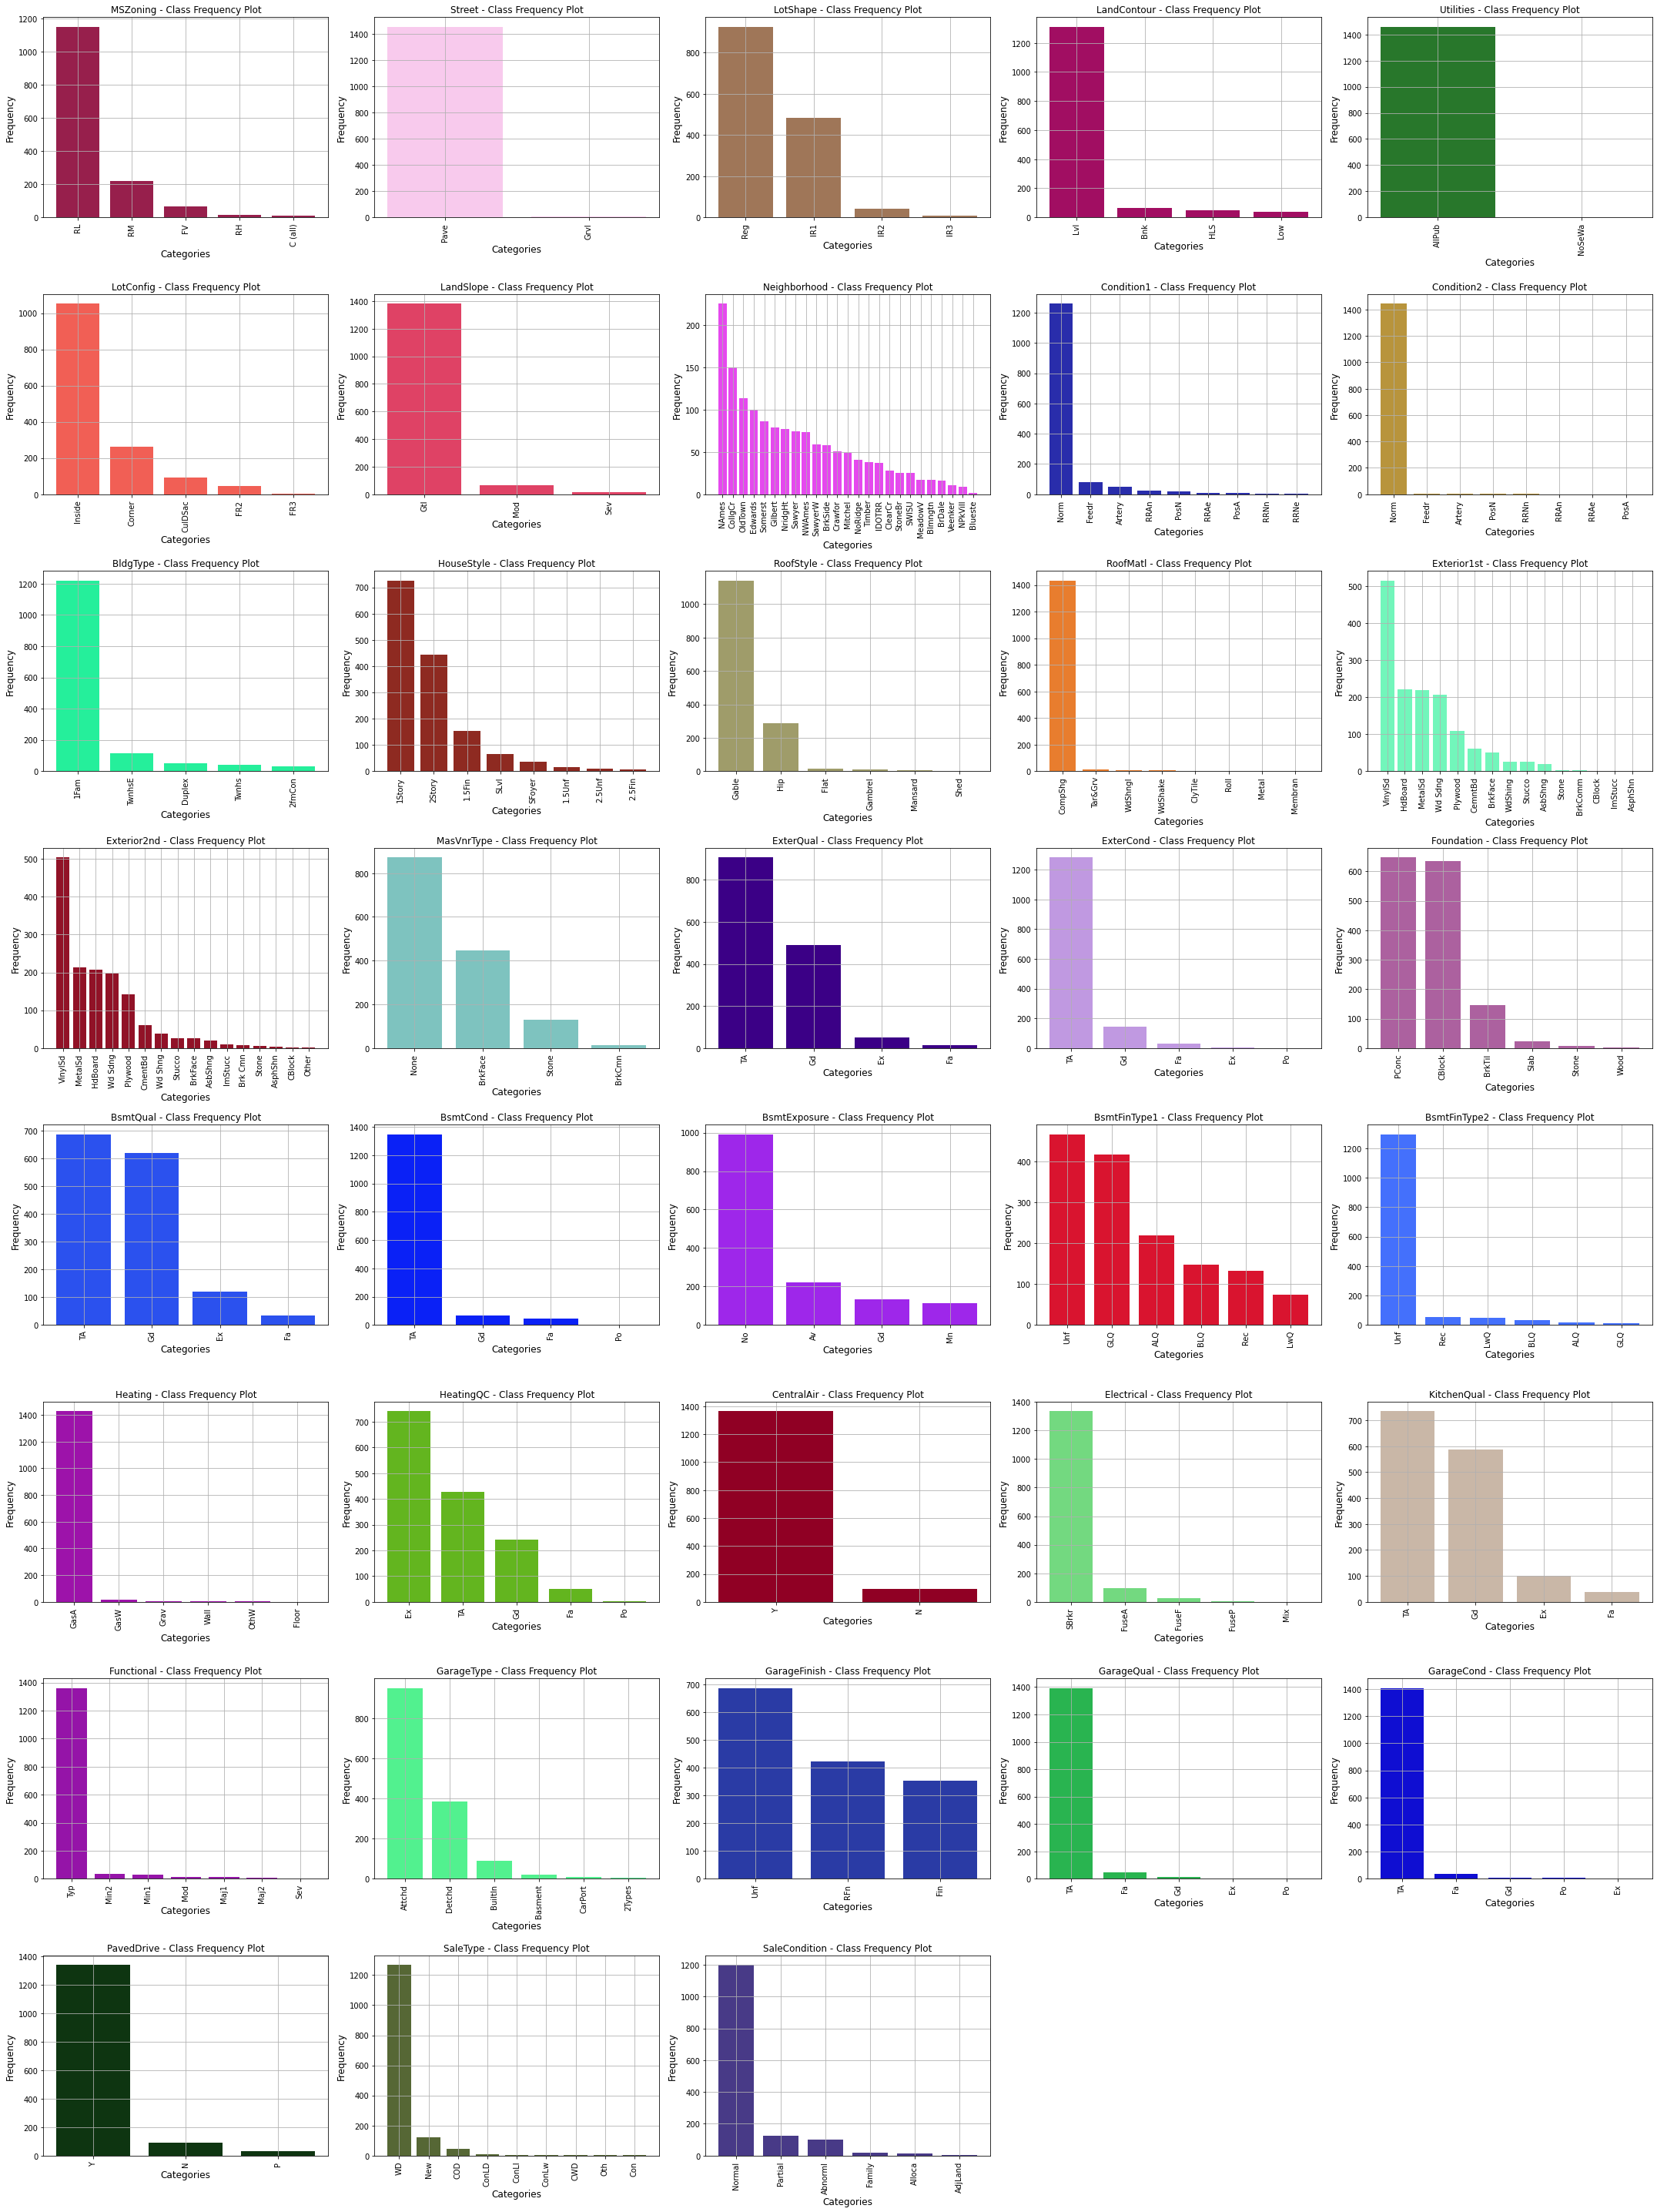

In [15]:
# Categorical columns frequency plot
# Rotate the ticks
fig_size = (30, 40)
nrows = 8
ncols = 5
plot_categ(nrows, ncols, df_main, categ_cols, fig_size)

**Categorical Plot observations**

* We observe that most of the columns have a class imbalance issue, which the data collection teams needs to take care of so that the instances across different datapoints have a uniform representation.

* Street, Utilities, GarageCond, GarageQual, CentralAir are some of the columns which have highly skewed representation of the class types. These predictor variables seems to be of high value for the prediciton of the the house sales value.

* On the other hand, GarageFinish is the only column which seems to be having a balanced class representation compared to the other categorical variable, which still is not near to the uniform representation.


In [16]:
def plot_hist(nrows, ncols, df, list_cols, fig_size):
    
    fig, ax = plt.subplots(nrows, ncols, figsize=fig_size)
    index = 0
    list_cols = list_cols.copy()
    list_cols.remove('Id')
    for i in range(nrows):
        for j in range(ncols):
            if index < len(list_cols):
                tup_color = [random.random() for x in range(3)]
                df.hist(column=list_cols[index], bins=100, ax=ax[i][j], alpha=0.5, color=tup_color)
                ax[i][j].set_title(f"Histogram - {list_cols[index]}", fontsize=18)
                ax[i][j].set_xlabel("Attribute Values - Bins", fontsize=12)
                ax[i][j].set_ylabel("Frequency", fontsize=12)
            else:
                ax[i][j].axis('off')
            
            index +=1
        

    plt.tight_layout()
    plt.show()

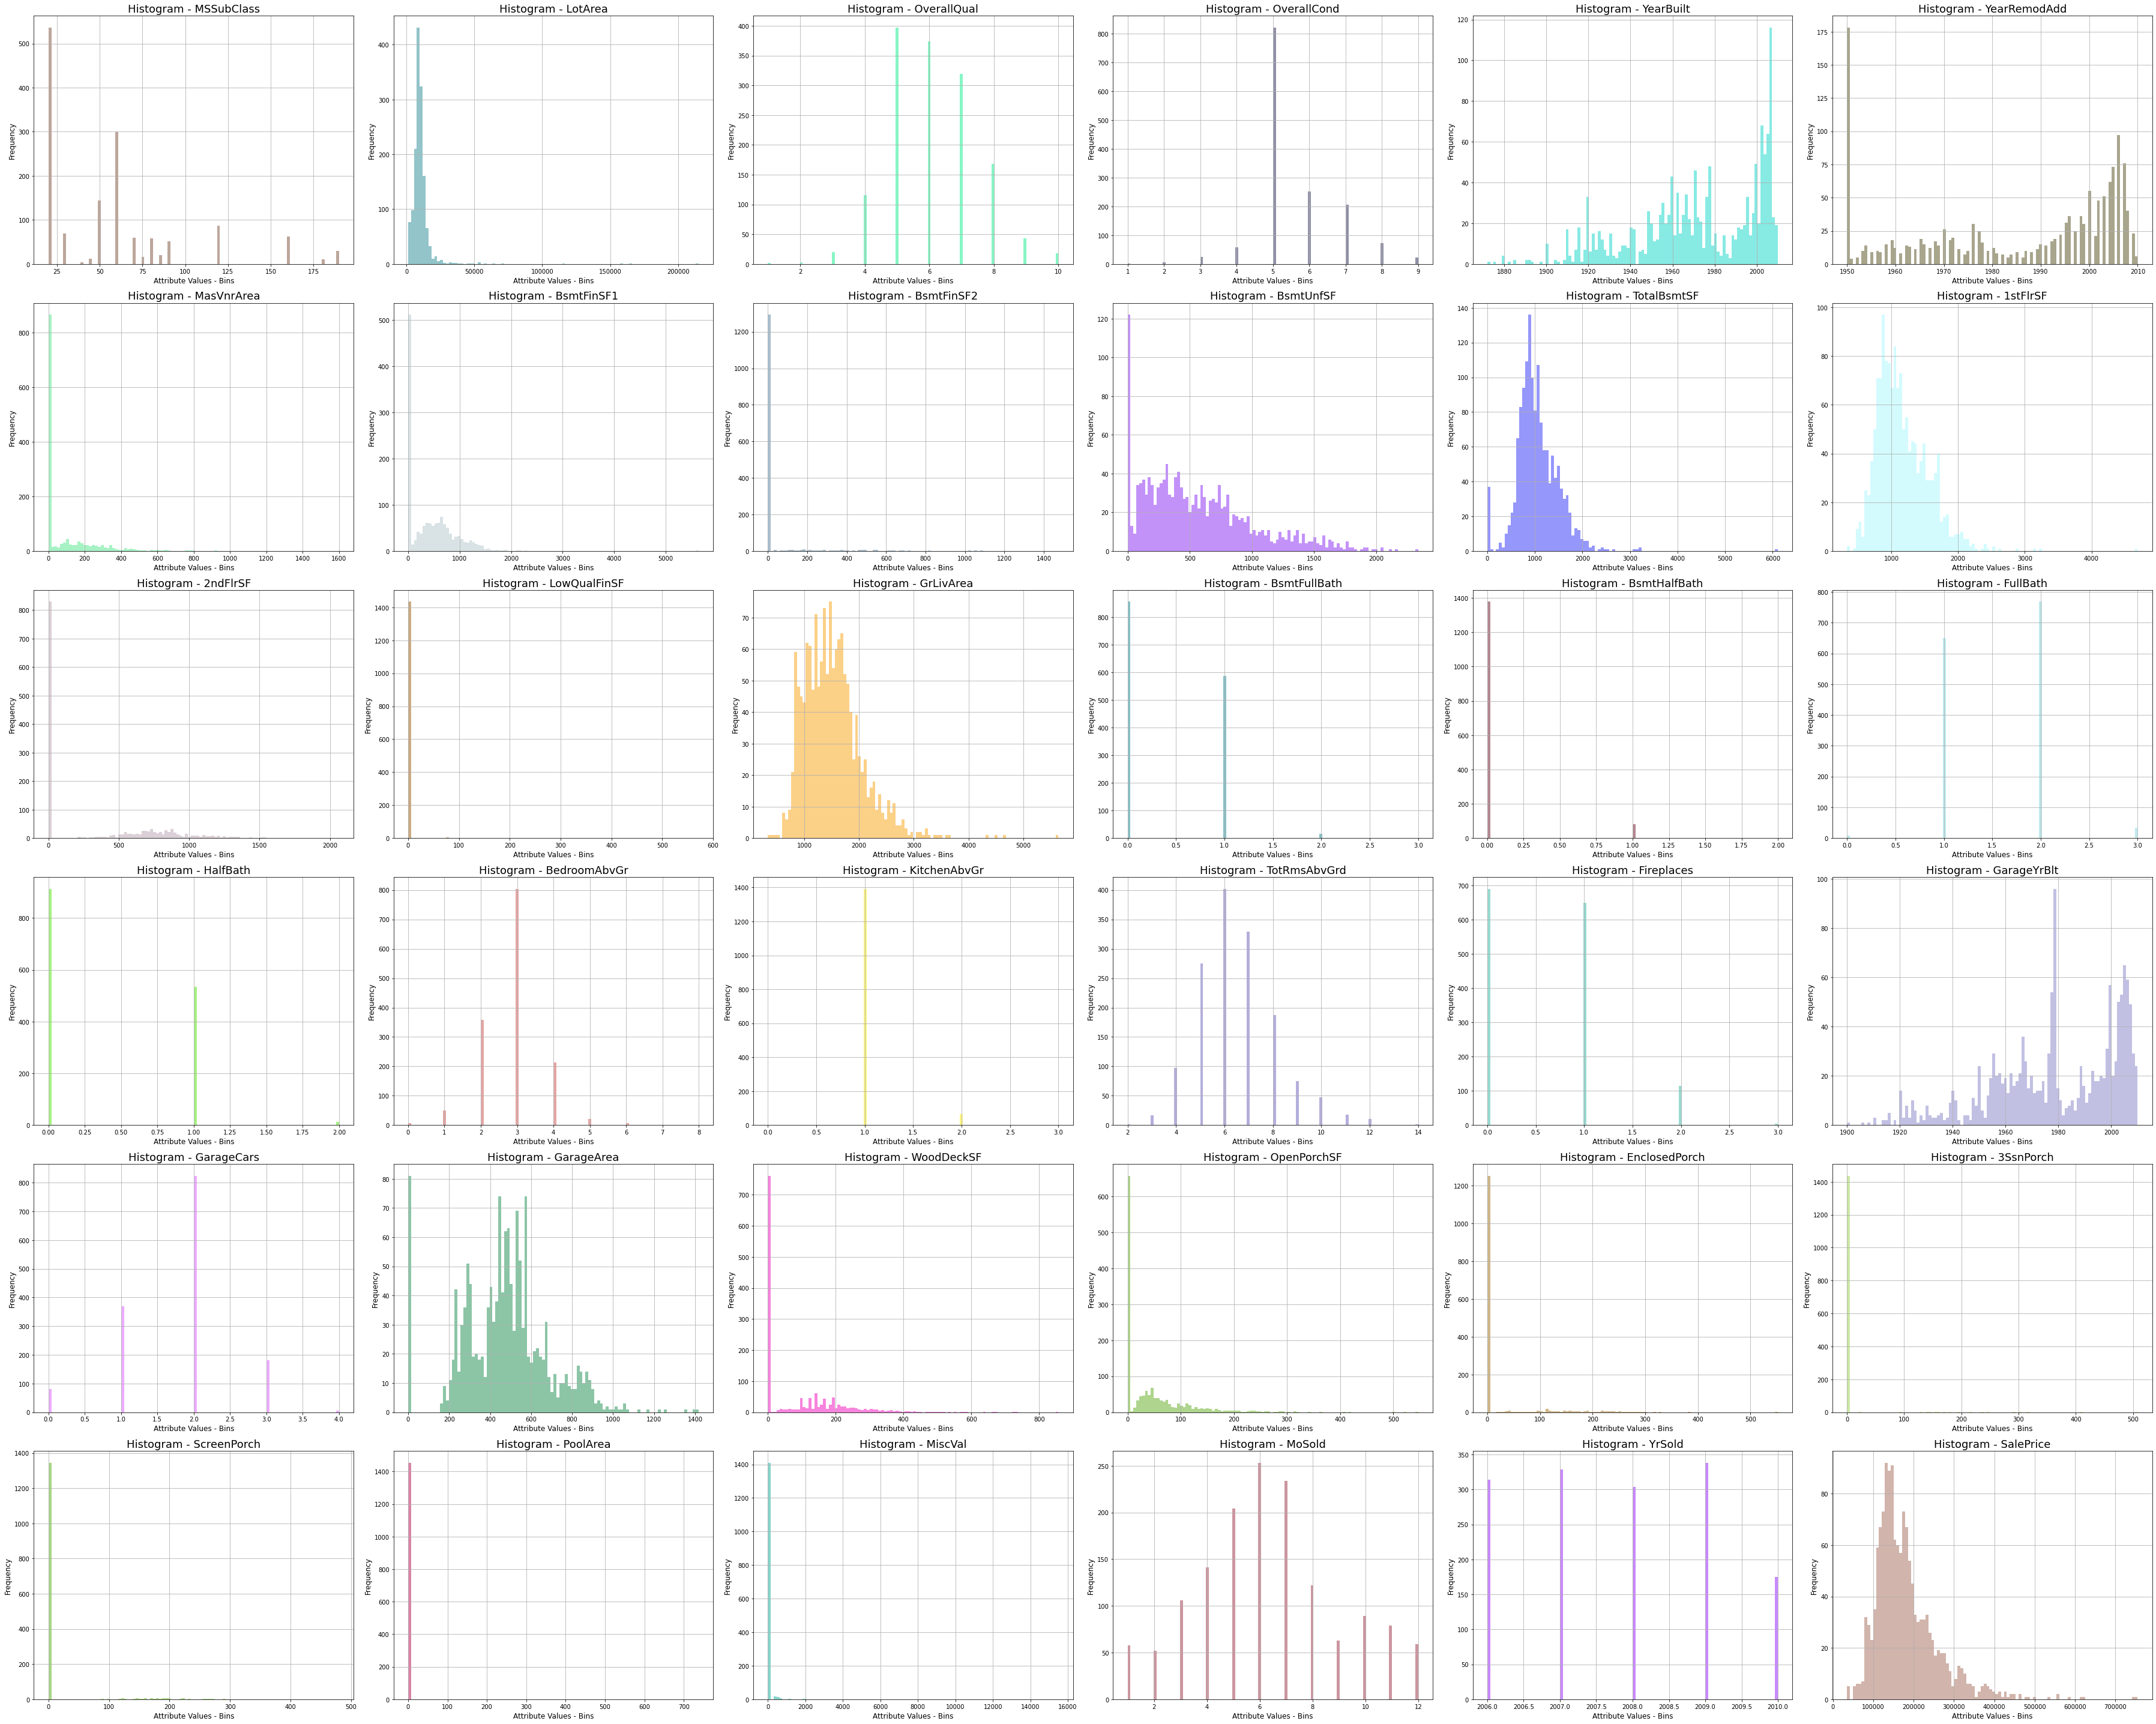

In [17]:
fig_size = (50, 40)
nrows = 6
ncols = 6
plot_hist(nrows, ncols, df_main, numeric_cols, fig_size)

**Histogram Plot observations**

* Discretized spaced out valued columns : MSSubclass, HalfBath, GarageCars, BedroomAbvGr, LowQualFinSF, KitchenAbvGr, OverallQual, MoSold, TotRmsAbvGrd, BsmtFullBath, OverallCond, YrSold and FullBath. We also observe that there are 2 Full bathrooms in the most of the houses. The Year 2007 and 2009 had the most houses sold. Most of the houses have 6 rooms found above the garden. Most of the Houses in the dataset have been given rating of 5.

* Right Skewed Distribution Columns : ScreePorch, 2ndFlrSF, MasVnrArea, Garage Area, LowQualFinSF, BsmtFinSF1, LotArea, MiscVal, WoodDeckSF, GrLivArea, BsmtFinSF2, OpenPorchSF, BsmtUnfSF. 

* Left Skewed Distribution Columns : There no columns found with left skewness in the dataset.

In [18]:
# Box plot for the numerical columns
# Normalize the numeric columns so that the values can be plotted on the same scale
def plot_box(df, list_cols, fig_size):
    
    plt.figure(figsize=fig_size)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_numer = df[list_cols]
    x_scaled = min_max_scaler.fit_transform(df_numer)
    df_normalized = pd.DataFrame(x_scaled)
    df_normalized.columns = list_cols
    sns.boxplot(y="variable", x="value", data=pd.melt(df_normalized), orient='h')
    plt.xlabel('Normalized Value', fontsize=15)
    plt.ylabel('Features', fontsize=15)         
    plt.title('Box Plot Analysis - Numeric Columns', fontsize=20)
    plt.tight_layout()
    plt.show()

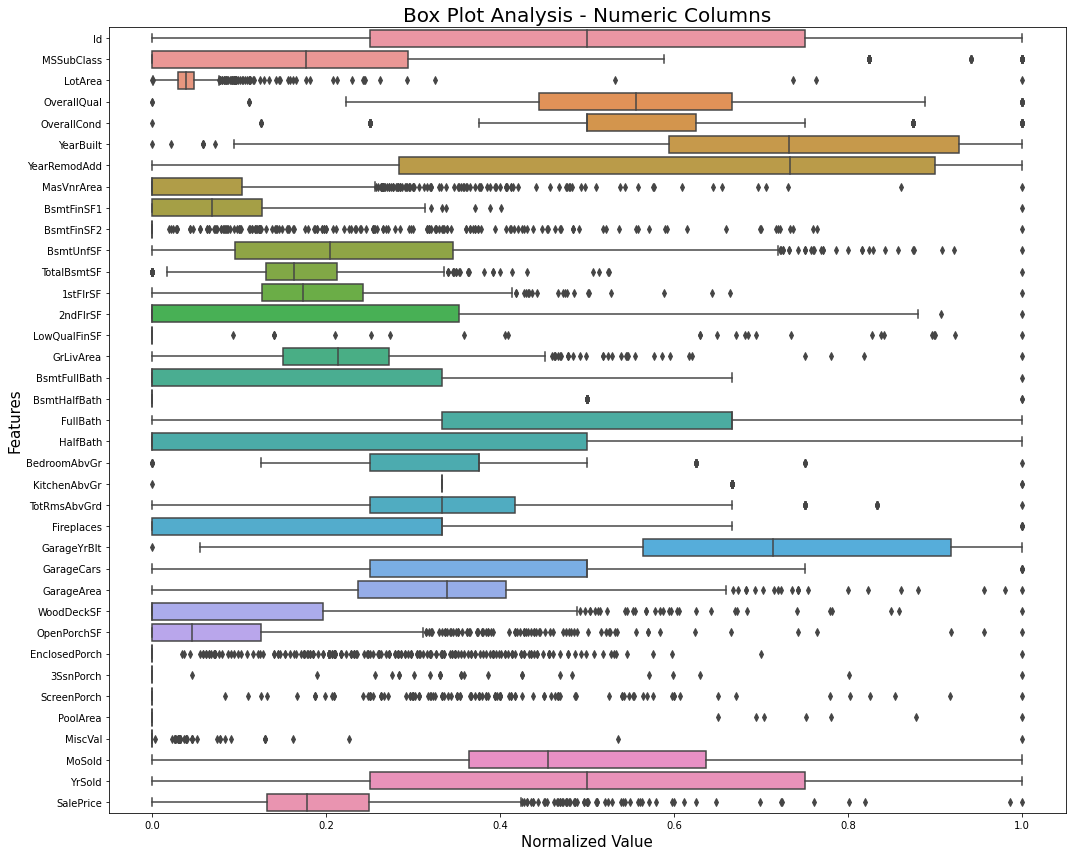

In [19]:
fig_size = (15, 12)
plot_box(df_main, numeric_cols, fig_size)

**Box Plot observations**

* The Box-plot show trends exact same as the histogram represents

* Most of the column have outlier value to be seen to the right i.e. larger values.

* GarageCar is an expection with left skew distribution.

* Rest, most of the observations are consistent with the histogram plot.

#### To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


In [20]:
numeric_cols_copy = numeric_cols.copy()
numeric_cols_copy.remove('Id')
corr = df_main[numeric_cols_copy].corr()

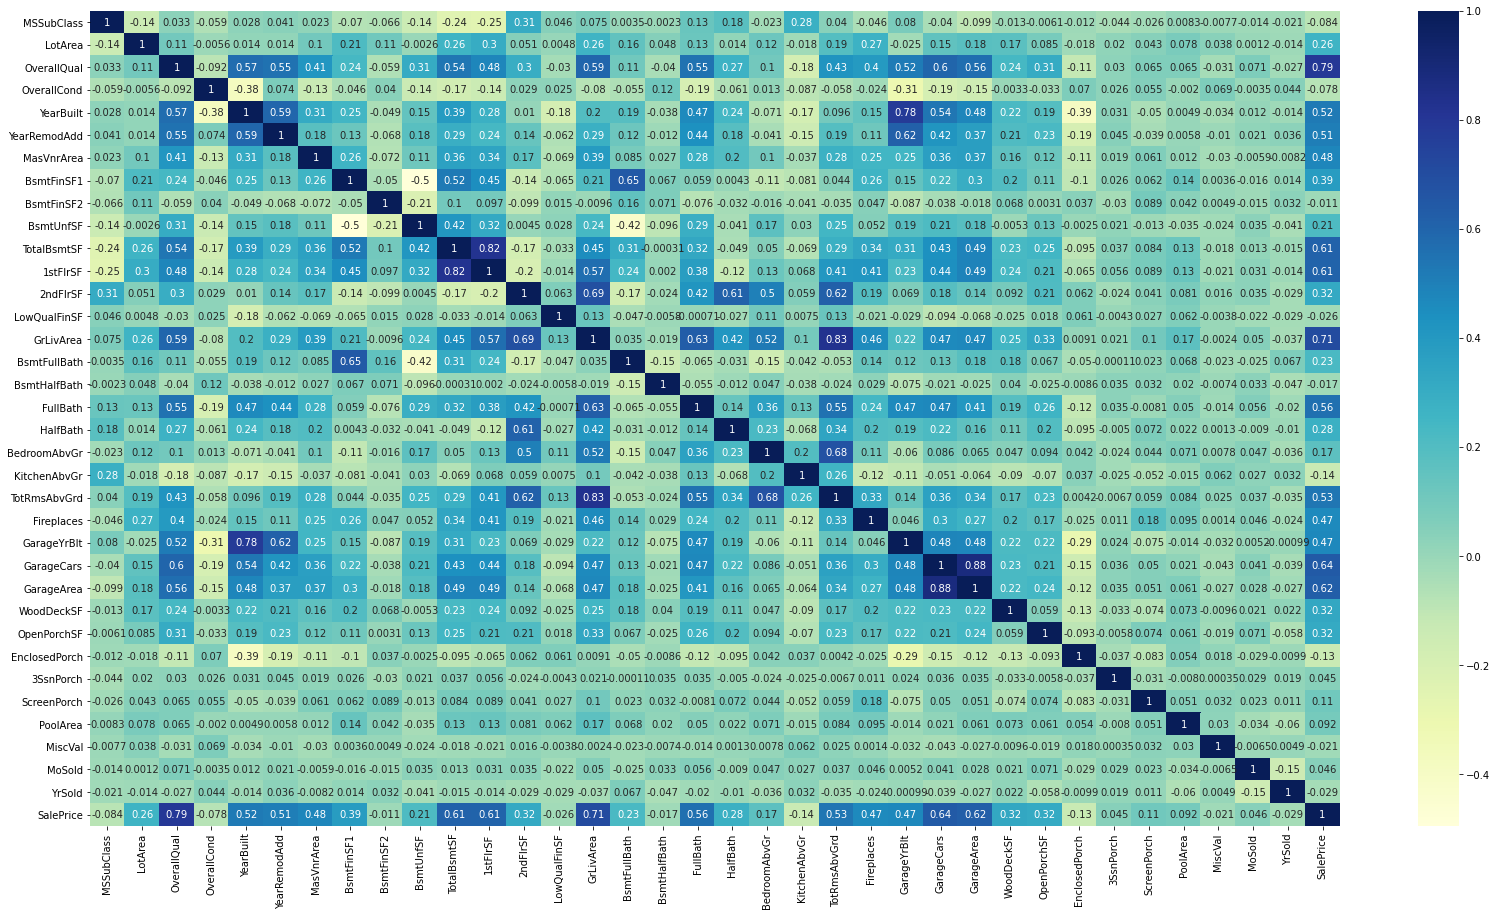

In [21]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(28, 15))

# heatmap
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

**Heat Map observations**

* SalesPrice has the highest correlation with the OverallQual predictor(positive correlation of 0.79), which is pretty evident too.

* SalesPrice has the second highest postive correlation with the GrLivArea. 

* The SalesPrice is highly negatively affected by the KitchenAbvGr predictor(-0.14).

* EnclosedPorch is the second highest negative influencer of the SalesPrice.



## Model Building and Evaluation

### Data Preparation

In [22]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(df_main[categ_cols], drop_first=True)
# Adding the results to the master dataframe
df_main= pd.concat([df_main, dummy1], axis=1)
df_main.drop(categ_cols, axis=1, inplace=True)

In [23]:
df_main.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


Since there are 233 columns are dummy variables creation, we will make use of top 30 correlated variables with the SalesPrice for our regression analysis.

In [24]:
# Selecting top 31 positive influencer for the lead score for  creating our model

train_ft= df_main.corr()['SalePrice']
train_col=list(train_ft.sort_values(ascending=False)[0:31].keys())
train_col = train_col[1:]
train_col

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'MasVnrArea',
 'GarageYrBlt',
 'Fireplaces',
 'ExterQual_Gd',
 'BsmtFinType1_GLQ',
 'Neighborhood_NridgHt',
 'BsmtFinSF1',
 'SaleType_New',
 'SaleCondition_Partial',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 'WoodDeckSF',
 'KitchenQual_Gd',
 '2ndFlrSF',
 'OpenPorchSF',
 'BsmtExposure_Gd',
 'Exterior2nd_VinylSd',
 'Exterior1st_VinylSd',
 'HalfBath']

In [25]:
# Remove the columns whih represent the year, since the magnitude of these columns is has a large number
# It influences the correlation value and thus end up in the top correlated features.
remove_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', ]

_ = [train_col.remove(col) for col in remove_cols]

assert set(train_col).intersection(set(remove_cols)) != [], "The remove_cols still in the train cols"


### Feature Transformation

In [26]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

X = df_main[train_col]
X = pd.DataFrame(scale(X))
X.columns = train_col
Y = df_main['SalePrice']

In [27]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1021, 27)
(438, 27)
(1021,)
(438,)


### Model Building

#### Non Regularized Linear Regression

In [28]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [29]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

180080.17099833154
[23270.17429833  -654.44768786  7212.31138698  1542.30252341
  2392.68149957 18264.59492389  2561.27764122   486.52207551
   357.349223    1012.50791097  5350.09196077  2627.1198438
  4244.21954823  8339.23936524  4086.99194616  3144.87267738
  3110.39396133 -1265.9327025   9152.57685889  3919.13090812
 -2258.94751491 13876.9167234    242.32170883  7457.00184929
  6770.91041933 -3243.47941739  2955.2712704 ]


In [30]:
from sklearn.metrics import r2_score, mean_squared_error

In [31]:
# The train and test evaluation of the Non regularized Linear Regression.

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

lm_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
lm_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
lm_metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
lm_metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
lm_metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
lm_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
lm_metric.append(mse_test_lr**0.5)

R2 Score Train : 0.8117377813615474
R2 Score Test: 0.8147765062793618
RSS Train : 1201244512453.2634
RSS Test : 522091782665.62665
MSE Train : 1176537230.610444
MSE Test : 1191990371.3827093


#### Ridge Regression

In [32]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.3s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [33]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


#### Best Hyperparameter value alpha(Ridge) : 500

In [34]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[13356.05324714  7882.88011498  5483.33364374  4655.88484418
  5628.80596001  6920.01554488  3801.29178833  3503.55294969
  2974.80844946  3356.93693395  6132.97293977  3109.04102101
  4486.40556134  6203.89109761  3754.78229018  2741.31484423
  2711.26052222   341.83631951  6975.25531833  3696.85501731
   -14.35140279  3626.19531042  1215.56396323  5996.97638434
  1751.39243363  1133.57722898  3325.12233846]


In [35]:
# The train and test evaluation of the Ridge Linear Regression.

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

ridge_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
ridge_metric .append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
ridge_metric .append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
ridge_metric .append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
ridge_metric .append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
ridge_metric .append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
ridge_metric .append(mse_test_lr**0.5)

R2 Score Train : 0.7990761836841036
R2 Score Test: 0.804349266442951
RSS Train : 1282034353553.1912
RSS Test : 551483174249.486
MSE Train : 1255665380.5614018
MSE Test : 1259094005.1358128


In [36]:
#### Lasso
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   12.6s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [37]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 1000}


#### Best Hyperparameter value alpha(Lasso) : 1000

In [38]:
#Fitting Ridge model for alpha = 1000 and printing coefficients which have been penalised

alpha = 1000

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=1000)

In [39]:
lasso.coef_

array([24135.83672874, 16680.25291783,  7723.67138682,  1179.83652792,
        2757.63273366,  5546.9319009 ,  1752.16552385,     0.        ,
         203.29233994,   903.99325522,  4969.79005313,   839.4427116 ,
        3925.25117977,  7530.07482166,  3720.13253881,  5291.42475809,
           0.        ,    -0.        ,  8661.15619334,  3347.38958117,
          -0.        ,     0.        ,     0.        ,  6736.79885111,
        3048.47366955,     0.        ,  2350.57182955])

In [40]:
# The train and test evaluation of the Lasso Linear Regression.

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

lasso_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
lasso_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
lasso_metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
lasso_metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
lasso_metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
lasso_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
lasso_metric.append(mse_test_lr**0.5)

R2 Score Train : 0.8097723448745775
R2 Score Test: 0.8153145661366743
RSS Train : 1213785370686.1213
RSS Test : 520575146603.7414
MSE Train : 1188820147.5867987
MSE Test : 1188527731.9720123


### Evaluation metric comparison between Linear, Ridge and Lasso

In [41]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': lm_metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(ridge_metric, name = 'Ridge Regression')
ls_metric = pd.Series(lasso_metric, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),8.117378e-01,7.990762e-01,8.097723e-01
1,R2 Score (Test),8.147765e-01,8.043493e-01,8.153146e-01
2,RSS (Train),1.201245e+12,1.282034e+12,1.213785e+12
3,RSS (Test),5.220918e+11,5.514832e+11,5.205751e+11
4,MSE (Train),3.430069e+04,3.543537e+04,3.447927e+04
5,MSE (Test),3.452521e+04,3.548371e+04,3.447503e+04


#### Observation

* The R2 score is highest for Lasso on the test set but is marignal w.r.t the Non regularized LR with a delta of 0.01.

* Following the above trend, the RSS and MSE are minimum for Lasso regularized LR and are marginal w.r.t the Non regularized LR.

### Compare the Linear, Ridge and Lasso per column Coefficents

In [42]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(30)

,Linear,Ridge,Lasso
OverallQual,23270.174298,13356.053247,24135.836729
GrLivArea,-654.447688,7882.880115,16680.252918
GarageCars,7212.311387,5483.333644,7723.671387
GarageArea,1542.302523,4655.884844,1179.836528
TotalBsmtSF,2392.681500,5628.805960,2757.632734
1stFlrSF,18264.594924,6920.015545,5546.931901
FullBath,2561.277641,3801.291788,1752.165524
TotRmsAbvGrd,486.522076,3503.552950,0.000000
Foundation_PConc,357.349223,2974.808449,203.292340
MasVnrArea,1012.507911,3356.936934,903.993255


#### Observation

* The obvious observation here is that, OverallQual has the highest weight across Non regular LR, ridge and Lasso.

* We also observe that GrLivArea has negative weight for the Non Regularized LR while it holds positive influence for ridge and lasso.

* TotalRmsAbvGrd have been penalized to have zero weight for Lasso, while it holds a magnitude of 486.52 and 3503.55 for Non Regularized LR and Ridge.

* We do observe that high negative weight predictors MasVnrType_Stone, KitchenQual_Gd and Exterior1st_VinylSd, had been reduced to zero weights by Lasso w.r.t Non regularized LR, which makes sense too.

* 2ndFlrSF is the only anomaly in the above observed trend where a low weight value predictor w.r.t Non regularized LR has been reduced to zero by Lasso.

* Going by the observation , most the coefficients have same scale value for the LR, ridge and lasso, although we observe the most of the negative coefficients for LR and Ridge have been reduced to zero by lasso, there being one anomaly, which has been pointed out in the above pointed.



### Final Model

* We see Lasso beats the Non Regularizd LR model marginally on the test set evaluation. Therefore, we can choose Lasso as the current best model.

* Let's get the top influencers and their magnitude for the Lasso model.

In [43]:
betas['Lasso'].sort_values(ascending=False)

OverallQual              24135.836729
GrLivArea                16680.252918
Neighborhood_NoRidge      8661.156193
GarageCars                7723.671387
Neighborhood_NridgHt      7530.074822
BsmtExposure_Gd           6736.798851
1stFlrSF                  5546.931901
SaleType_New              5291.424758
Fireplaces                4969.790053
BsmtFinType1_GLQ          3925.251180
BsmtFinSF1                3720.132539
WoodDeckSF                3347.389581
Exterior2nd_VinylSd       3048.473670
TotalBsmtSF               2757.632734
HalfBath                  2350.571830
FullBath                  1752.165524
GarageArea                1179.836528
MasVnrArea                 903.993255
ExterQual_Gd               839.442712
Foundation_PConc           203.292340
KitchenQual_Gd              -0.000000
TotRmsAbvGrd                 0.000000
Exterior1st_VinylSd          0.000000
SaleCondition_Partial        0.000000
MasVnrType_Stone            -0.000000
OpenPorchSF                  0.000000
2ndFlrSF    

### Top 5 Predictors

* OverallQual, GrLivArea, Neighborhood_NoRidge, GarageCars and Neighborhood_NridgHt are the top 5 influencers of the sales price.

* **OverallQual[24135.8]** - the overall material and finish of the house - is an evident and strong sales price influencer without a doubt and should be on the top of the list.

* **GrLivArea[16680.2]** - The living area above the ground per square feet seems to be another strong influencer, it means, the price would be higher for houses with lesser basement area and more above ground area.

* **Neighborhood_NoRidge[8661.1]** - The neighborhood being the North Ridge produces highest sales price.

* **GarageCars[7723.6]** - Size of the garage in car capacity. Thus, if garage has more capacity of car parking, more is the sales price.

* **Neighborhood_NridgHt[7530.0]** - The property in the Northridge Heights neighborhood again is a strong postive influencer in the sales price.Z

## Assignment Part-2

### Question 1 - Evaluate the model on double the alpha values for Ridge and Lasso


In [48]:
#Fitting Ridge model for alpha = 1000 and printing coefficients which have been penalised
alpha = 1000
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

ridge_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
ridge_metric .append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
ridge_metric .append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
ridge_metric .append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
ridge_metric .append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
ridge_metric .append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")

[10617.5813388   7206.39507837  5258.40889689  4821.52368253
  5685.08159334  6287.11052887  3954.421237    3814.5380002
  3310.41383101  3749.61941052  5650.66892901  3150.59229829
  4221.614777    5218.23557906  3695.57171254  2531.68327157
  2503.92723894   956.73995918  5872.64892009  3458.14290602
   748.45526788  3261.29236018  1538.61549462  5076.25229626
  1694.36488456  1342.49371956  3104.83405155]
R2 Score Train : 0.7849036757722195
R2 Score Test: 0.7889116350662204
RSS Train : 1372464857772.1287
RSS Test : 594997419250.0057
MSE Train : 1344235903.7924864
MSE Test : 1358441596.4612002


In [49]:
#Fitting Lasso model for alpha = 200 and printing coefficients which have been penalised

alpha =2000
lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

lasso_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
lasso_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
lasso_metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
lasso_metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
lasso_metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
lasso_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
lasso_metric.append(mse_test_lr**0.5)

R2 Score Train : 0.8071036711090345
R2 Score Test: 0.8118087698422479
RSS Train : 1230813374178.1172
RSS Test : 530456978547.69684
MSE Train : 1205497917.9021716
MSE Test : 1211088992.1180294


In [50]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': lm_metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(ridge_metric, name = 'Ridge Regression')
ls_metric = pd.Series(lasso_metric, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),8.117378e-01,7.849037e-01,8.071037e-01
1,R2 Score (Test),8.147765e-01,7.889116e-01,8.118088e-01
2,RSS (Train),1.201245e+12,1.372465e+12,1.230813e+12
3,RSS (Test),5.220918e+11,5.949974e+11,5.304570e+11
4,MSE (Train),3.430069e+04,3.666382e+04,3.472028e+04
5,MSE (Test),3.452521e+04,NaN,3.480070e+04


In [53]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(30)

,Linear,Ridge,Lasso
OverallQual,23270.174298,10617.581339,25067.621825
GrLivArea,-654.447688,7206.395078,17574.194017
GarageCars,7212.311387,5258.408897,8110.760307
GarageArea,1542.302523,4821.523683,976.384736
TotalBsmtSF,2392.681500,5685.081593,3255.564987
1stFlrSF,18264.594924,6287.110529,4700.572545
FullBath,2561.277641,3954.421237,956.600593
TotRmsAbvGrd,486.522076,3814.538000,0.000000
Foundation_PConc,357.349223,3310.413831,338.210416
MasVnrArea,1012.507911,3749.619411,792.026868


In [54]:
betas['Lasso'].sort_values(ascending=False)

OverallQual              25067.621825
GrLivArea                17574.194017
GarageCars                8110.760307
Neighborhood_NoRidge      7964.335155
Neighborhood_NridgHt      6886.004510
BsmtExposure_Gd           6094.071129
1stFlrSF                  4700.572545
SaleType_New              4532.635345
Fireplaces                4481.855938
BsmtFinType1_GLQ          3823.149725
TotalBsmtSF               3255.564987
BsmtFinSF1                3248.257964
WoodDeckSF                2890.408097
Exterior2nd_VinylSd       2429.093579
HalfBath                  1152.259283
GarageArea                 976.384736
FullBath                   956.600593
MasVnrArea                 792.026868
ExterQual_Gd               470.630803
Foundation_PConc           338.210416
KitchenQual_Gd               0.000000
TotRmsAbvGrd                 0.000000
Exterior1st_VinylSd          0.000000
SaleCondition_Partial        0.000000
MasVnrType_Stone             0.000000
OpenPorchSF                  0.000000
2ndFlrSF    

### Question 3 : Building model dropping the top 5 predictors from the current best model



In [56]:
_ = [train_col.remove(x) for x in ['OverallQual', 'GrLivArea', 'GarageCars', 'Neighborhood_NoRidge', 
                  'Neighborhood_NridgHt']]

X = df_main[train_col]
X = pd.DataFrame(scale(X))
X.columns = train_col
Y = df_main['SalePrice']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1021, 22)
(438, 22)
(1021,)
(438,)


In [59]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)


LinearRegression()

In [60]:
# LR model Evalution 
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

lm_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
lm_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
lm_metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
lm_metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
lm_metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
lm_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
lm_metric.append(mse_test_lr**0.5)

R2 Score Train : 0.7575033328229943
R2 Score Test: 0.7724229667484839
RSS Train : 1547298193133.51
RSS Test : 641474235245.9998
MSE Train : 1515473254.7830656
MSE Test : 1464553048.5068488


In [61]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.8s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [62]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [63]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[10987.76366756  9331.21492203 14909.7243817   5310.5417044
  3751.65686591  6571.3018303   6916.65992932  9744.00497558
  6811.31550726  8462.15465892  1753.03895047  3374.0726485
  3337.08110552   857.87073212  4572.24892222 -1494.36353621
 13425.4828816    699.21874184  7708.41528674  2118.09869386
   702.27105283  4875.59483305]


In [64]:
# Ridge Regression Evaluation 

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

ridge_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
ridge_metric .append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
ridge_metric .append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
ridge_metric .append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
ridge_metric .append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
ridge_metric .append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
ridge_metric .append(mse_test_lr**0.5)

R2 Score Train : 0.7550470823297293
R2 Score Test: 0.7741130163470823
RSS Train : 1562970787707.1013
RSS Test : 636710471265.5171
MSE Train : 1530823494.32625
MSE Test : 1453676875.035427


In [65]:
#### Lasso
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)
print(model_cv.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 1000}


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    5.7s finished


In [66]:
#Fitting Lasso model for alpha = 1000 and printing coefficients which have been penalised

alpha =1000

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=1000)

In [67]:
alpha =1000
lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

lasso_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 Score Train : {r2_train_lr}")
lasso_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 Score Test: {r2_test_lr}")
lasso_metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS Train : {rss1_lr}")
lasso_metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS Test : {rss2_lr}")
lasso_metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE Train : {mse_train_lr}")
lasso_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE Test : {mse_test_lr}")
lasso_metric.append(mse_test_lr**0.5)

R2 Score Train : 0.7559273998938478
R2 Score Test: 0.769134963492762
RSS Train : 1557353746482.5713
RSS Test : 650742171222.7356
MSE Train : 1525321984.801735
MSE Test : 1485712719.686611


In [68]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': lm_metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(ridge_metric, name = 'Ridge Regression')
ls_metric = pd.Series(lasso_metric, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),7.575033e-01,7.550471e-01,7.559274e-01
1,R2 Score (Test),7.724230e-01,7.741130e-01,7.691350e-01
2,RSS (Train),1.547298e+12,1.562971e+12,1.557354e+12
3,RSS (Test),6.414742e+11,6.367105e+11,6.507422e+11
4,MSE (Train),3.892908e+04,3.912574e+04,3.905537e+04
5,MSE (Test),3.826948e+04,3.812711e+04,3.854494e+04


In [69]:
# Weights comparison

betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(30)

,Linear,Ridge,Lasso
GarageArea,11079.280132,10987.763668,11238.082723
TotalBsmtSF,8505.291185,9331.214922,9130.971462
1stFlrSF,21028.715205,14909.724382,19767.439599
FullBath,3824.409982,5310.541704,3621.242074
TotRmsAbvGrd,-794.134337,3751.656866,0.000000
Foundation_PConc,6704.930095,6571.301830,6643.842610
MasVnrArea,6581.183302,6916.659929,6572.307344
Fireplaces,9610.837896,9744.004976,9483.635807
ExterQual_Gd,7355.032075,6811.315507,5717.054845
BsmtFinType1_GLQ,9487.876947,8462.154659,9074.529474


In [70]:
# Since the LR model is the best performing model on the test set.
# Looking at the top predictors for the same.

betas['Linear'].sort_values(ascending=False)

1stFlrSF                 21028.715205
2ndFlrSF                 19899.685933
GarageArea               11079.280132
Fireplaces                9610.837896
BsmtFinType1_GLQ          9487.876947
TotalBsmtSF               8505.291185
BsmtExposure_Gd           7993.579349
ExterQual_Gd              7355.032075
Foundation_PConc          6704.930095
MasVnrArea                6581.183302
Exterior2nd_VinylSd       4949.291864
WoodDeckSF                4427.021797
HalfBath                  3892.437450
FullBath                  3824.409982
SaleType_New              3500.222227
SaleCondition_Partial     3461.847646
MasVnrType_Stone           942.450115
BsmtFinSF1                 187.160410
OpenPorchSF                 -9.309332
TotRmsAbvGrd              -794.134337
Exterior1st_VinylSd      -2012.951029
KitchenQual_Gd           -2882.122069
Name: Linear, dtype: float64

#### The five most important predictor variables now are

* 1stFlrSF
* 2nd FlrSF
* GarageArea 
* Fireplaces
* BsmtFinType1_GLQ 
